## Data Loader

In [69]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

## Download dataset

In [70]:
ROOT_DATA_DIR = "FashionMNISTDir"

train_data = datasets.FashionMNIST(
    root = ROOT_DATA_DIR,
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = datasets.FashionMNIST(
    root = ROOT_DATA_DIR,
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

In [71]:
train_data.data.shape, test_data.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [72]:
label_map = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

## Visualize one sample

In [73]:
def view_sample_image(data, index, label_map):
    plt.imshow(data.data[index], cmap='gray')
    plt.title(f"Data lable: {label_map[data.targets[index].item()]}")
    plt.axis("off")

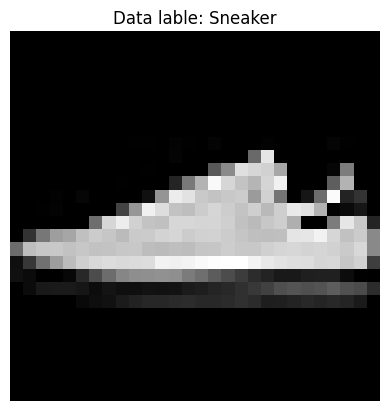

In [74]:
view_sample_image(train_data, index=6, label_map =label_map)

## Create the dataloader

In [75]:
BATCH_SIZE = 64

train_data_loader = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_data_loader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [76]:
for data, label in test_data_loader:
    print(data.shape)
    print(label.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [77]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [78]:
class CNN(nn.Module):
    def __init__(self, in_, out_):
        super(CNN, self).__init__()

        self.conv_pool_01 = nn.Sequential(
            nn.Conv2d(in_channels=in_,
                      out_channels=8,
                      kernel_size=5,
                      stride=1,
                      padding=0
                      ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_pool_02 = nn.Sequential(
            nn.Conv2d(in_channels=8,
                      out_channels=16,
                      kernel_size=5,
                      stride=1,
                      padding=0
                      ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.Flatten = nn.Flatten()
        self.FC_01 = nn.Linear(in_features=16*4*4, out_features=128)
        self.FC_02 = nn.Linear(in_features=128, out_features=64)
        self.FC_03 = nn.Linear(in_features=64, out_features=out_)

    def forward(self, x):
        x = self.conv_pool_01(x)
        x = self.conv_pool_02(x)
        x = self.Flatten(x)
        x = self.FC_01(x)
        x = self.FC_02(x)
        x = self.FC_03(x)
        return x

In [79]:
model = CNN(1,10)
model.to(device)

CNN(
  (conv_pool_01): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool_02): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (FC_01): Linear(in_features=256, out_features=128, bias=True)
  (FC_02): Linear(in_features=128, out_features=64, bias=True)
  (FC_03): Linear(in_features=64, out_features=10, bias=True)
)

In [80]:
model

CNN(
  (conv_pool_01): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool_02): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (FC_01): Linear(in_features=256, out_features=128, bias=True)
  (FC_02): Linear(in_features=128, out_features=64, bias=True)
  (FC_03): Linear(in_features=64, out_features=10, bias=True)
)

## Count no. of trainable parameters

In [81]:
def count_params(model):
    model_params = {"Modules": list(), "Parameters": list()}
    total = 0
    for name, parameters in model.named_parameters():
        if not parameters.requires_grad:
            continue
        param = parameters.numel()
        model_params["Modules"].append(name)
        model_params["Parameters"].append(param)
        total += param

    df = pd.DataFrame(model_params)
    df = df.style.set_caption(f"Total Trainable Parameters: {total}")
    return df


In [82]:
count_params(model)

,Modules,Parameters
0,conv_pool_01.0.weight,200
1,conv_pool_01.0.bias,8
2,conv_pool_02.0.weight,3200
3,conv_pool_02.0.bias,16
4,FC_01.weight,32768
5,FC_01.bias,128
6,FC_02.weight,8192
7,FC_02.bias,64
8,FC_03.weight,640
9,FC_03.bias,10


In [83]:
next(model.parameters()).is_cuda

True

## Training loop

In [84]:
learning_rate = 0.001
num_epochs = 30

In [85]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [86]:
n_total_steps = len(train_data_loader)
n_total_steps

938

In [87]:
600000 / BATCH_SIZE

9375.0

In [88]:
for epoch in range(num_epochs):
    with tqdm(train_data_loader) as tqdm_epoch:
        for images, labels in tqdm_epoch:
            tqdm_epoch.set_description(f"Epoch {epoch+1}/{num_epochs}")

            images = images.to(device)
            labels = labels.to(device)

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            tqdm_epoch.set_postfix(loss=loss.item())

Epoch 30/30: 100%|██████████| 938/938 [00:12<00:00, 78.13it/s, loss=0.184]


## Save trained model

In [89]:
os.makedirs("model", exist_ok=True)
model_file = os.path.join("model", "CNN_model.pth")
torch.save(model, model_file)

In [90]:
model = torch.load("model/CNN_model.pth", weights_only=False)

## Model evaluation

In [91]:
pred = np.array([])
target = np.array([])

In [92]:
with torch.no_grad():
    for bach, data in enumerate(test_data_loader):
        image, label = data[0].to(device), data[1].to(device)

        y_pred = model(image)

        pred = np.concatenate((pred, torch.argmax(y_pred, 1).cpu().numpy()))
        target = np.concatenate((target, label.cpu().numpy()))

In [93]:
cm = confusion_matrix(target, pred)

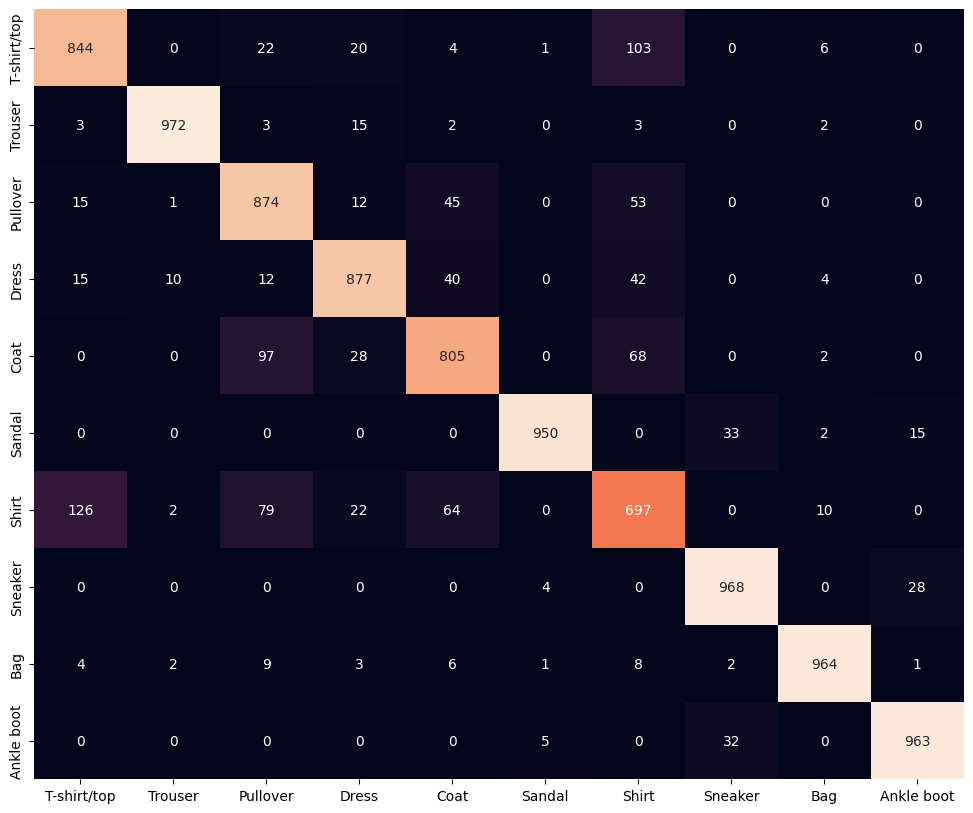

In [94]:
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.values(), yticklabels=label_map.values(), cbar=False)
plt.show()

## Prediction

In [95]:
data = next(iter(test_data_loader))

In [96]:
len(data)

2

In [97]:
images, label = data

In [98]:
images.shape

torch.Size([64, 1, 28, 28])

In [99]:
label.shape

torch.Size([64])

torch.Size([1, 28, 28])


'Pullover'

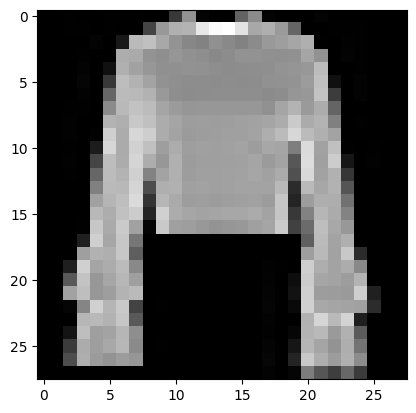

In [100]:
img = images[0]
print(img.shape)
plt.imshow(img.permute(1,2,0), cmap='gray')
label_map[label[0].item()]

In [101]:
img.shape, img.squeeze().shape, img.unsqueeze(1).shape

(torch.Size([1, 28, 28]), torch.Size([28, 28]), torch.Size([1, 1, 28, 28]))

In [102]:
logit = model(img.unsqueeze(1).to(device))
logit

tensor([[ 6.0160e+00,  4.4387e-03,  1.1509e+01,  5.0703e+00,  6.0872e+00,
         -1.2974e+01,  1.1285e+01, -2.8734e+01, -1.8262e+00, -2.0929e+01]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [103]:
sum([  6.6154,  10.2033,  -1.7328,   6.9131,   2.9423, -11.5645,   7.2617,
          -5.4986,  -7.4470, -12.7993])

-5.1064

In [104]:
pred_prob = F.softmax(logit)
pred_prob

/tmp/ipython-input-3149835973.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_prob = F.softmax(logit)


tensor([[2.2754e-03, 5.5755e-06, 5.5266e-01, 8.8383e-04, 2.4434e-03, 1.2874e-11,
         4.4173e-01, 1.8414e-18, 8.9383e-07, 4.5165e-15]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [105]:
sum([2.4730e-02, 8.9414e-01, 5.8563e-06, 3.3305e-02, 6.2807e-04, 3.1461e-10,
         4.7195e-02, 1.3557e-07, 1.9319e-08, 9.1522e-11])

1.000004081595132

In [106]:
argmax = torch.argmax(pred_prob).item()

In [107]:
label_map[argmax]

'Pullover'

In [113]:
def predict(data, model, label_map, device, idx=0):
    images, labels = data
    img = images[idx]
    label = labels[idx]

    plt.imshow(img.permute(1,2,0), cmap='gray')
    reshape_img = img.unsqueeze(1).to(device)
    logits = model(reshape_img)
    pred_prob = F.softmax(logits, dim=1)
    argmax = torch.argmax(pred_prob).item()
    predicted_label = label_map[argmax]
    actual_label = label_map[label.item()]
    plt.title(f"Acutual: {actual_label} | Prediced: {predicted_label}")
    return predicted_label, actual_label

('T-shirt/top', 'T-shirt/top')

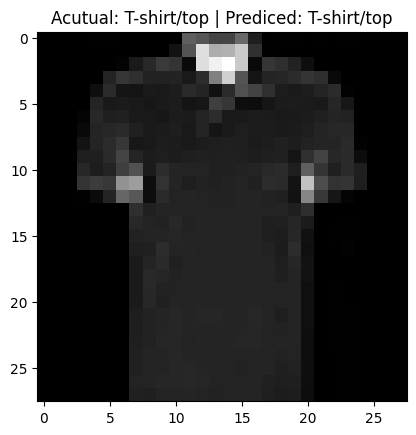

In [114]:
data = next(iter(test_data_loader))
predict(data, model, label_map, device, idx=0)

In [ ]:
# [batch_size, channel, row, col] -> Images excepted.
# [1, 1, 28, 28]